Building HHL circuit with full QPE and CORDIC structure...
...Done.

Drawing circuit diagram...


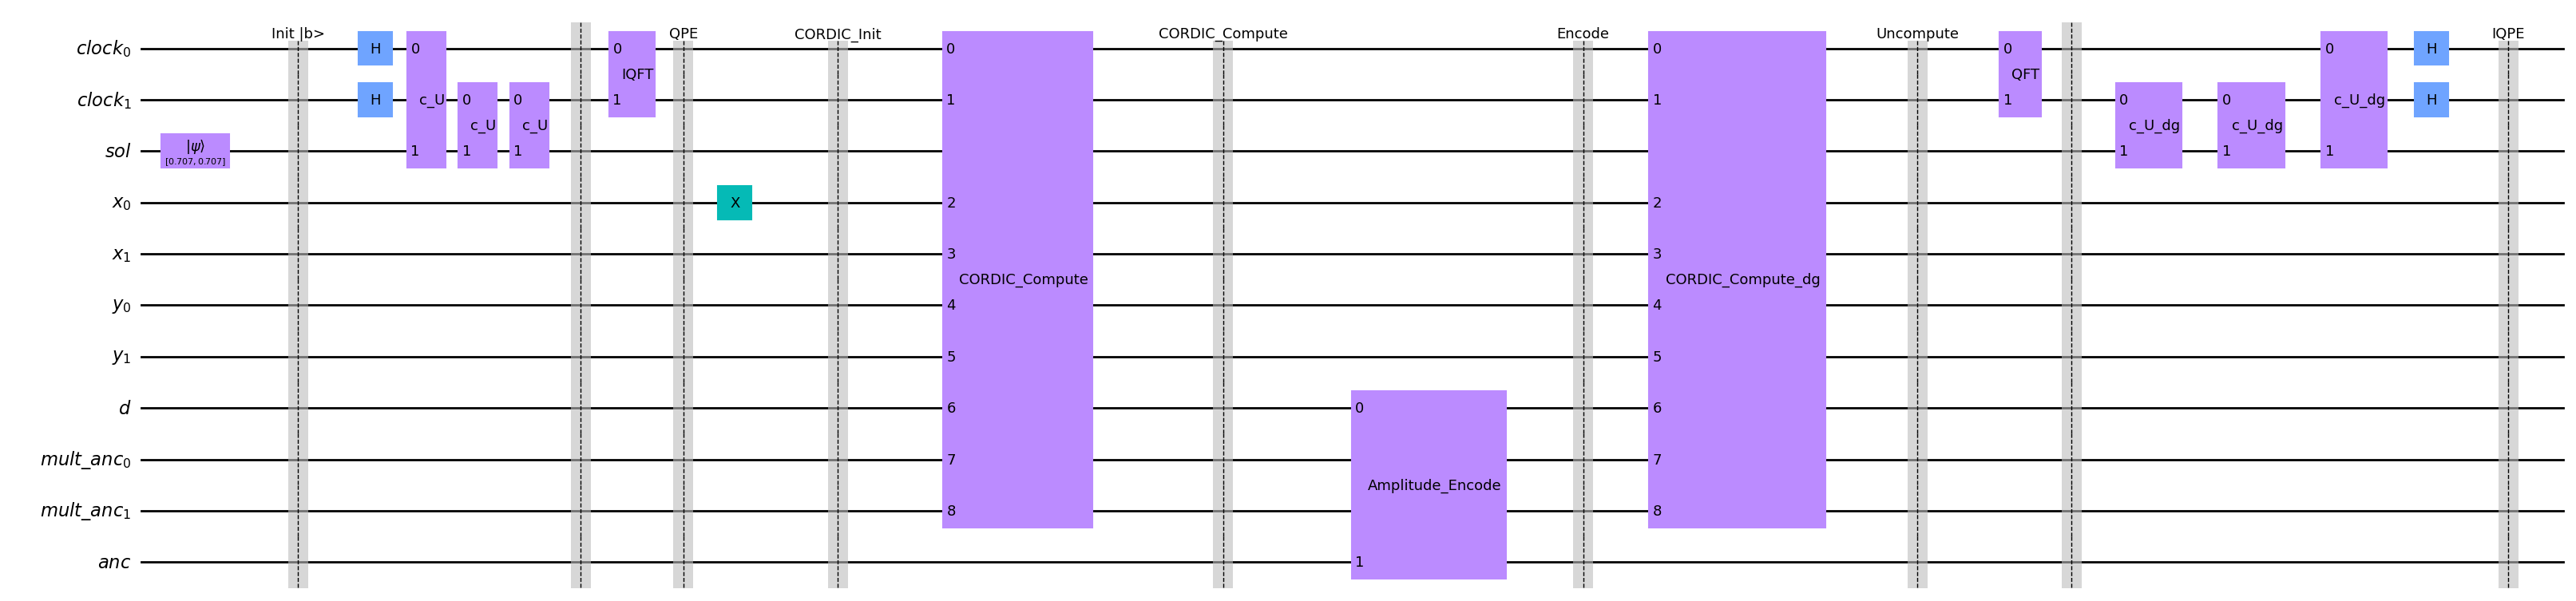


Preparing to run simulation for statevector...
...Simulation complete.

Analyzing results...

--- Results & Comparison ---
Classical Solution (Normalized): [0.7071 0.7071]
HHL Solution Vector (Normalized): [0.7071-0.j 0.7071-0.j]
Cosine Similarity (Fidelity):   1.0000


In [7]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from math import pi, atan
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from scipy.linalg import expm

# --- CORDIC Computation Circuit (Structural Placeholder) ---
def build_cordic_computation_circuit(
    input_reg: QuantumRegister, x_reg: QuantumRegister, y_reg: QuantumRegister,
    d_reg: QuantumRegister, ancilla_reg: QuantumRegister, label: str = "CORDIC_Compute"
) -> QuantumCircuit:
    n_bits = input_reg.size
    circuit = QuantumCircuit(input_reg, x_reg, y_reg, d_reg, ancilla_reg, name=label)
    for i in range(1, n_bits):
        circuit.cx(input_reg[i], d_reg[i-1])
        circuit.barrier()
        for j in range(n_bits):
            circuit.cswap(d_reg[i-1], x_reg[j], y_reg[j])
        circuit.barrier()
        circuit.cz(y_reg[i-1], x_reg[i-1])
        circuit.ccx(input_reg[i-1], x_reg[i-1], ancilla_reg[0])
        circuit.barrier()
    return circuit

# --- Amplitude Encoding Circuit ---
def build_amplitude_encoding_circuit(
    d_reg: QuantumRegister, ancilla_qubit: QuantumRegister, label: str = "Amplitude_Encode"
) -> QuantumCircuit:
    n_bits = d_reg.size
    circuit = QuantumCircuit(d_reg, ancilla_qubit, name=label)
    circuit.ry(pi / 4, ancilla_qubit)
    for j in range(n_bits):
        mu_j = atan(2**-(j+1))
        circuit.x(d_reg[j])
        circuit.cry(2 * mu_j, d_reg[j], ancilla_qubit)
        circuit.x(d_reg[j])
        circuit.cry(-2 * mu_j, d_reg[j], ancilla_qubit)
    return circuit

# --- Helper to create the Unitary for QPE ---
def create_unitary(matrix: np.ndarray, t: float) -> QuantumCircuit:
    op = expm(1j * matrix * t)
    circ = QuantumCircuit(int(np.log2(matrix.shape[0])), name="U")
    circ.unitary(op, range(circ.num_qubits))
    return circ

# --- Main HHL Circuit Builder ---
def get_hhl_circuit_with_cordic(A, b):
    n_clock = 2
    n_sol = int(np.log2(A.shape[0]))
    n_cordic = 2
    
    qr_clock = QuantumRegister(n_clock, name="clock")
    qr_solution = QuantumRegister(n_sol, name="sol")
    qr_x = QuantumRegister(n_cordic, name="x")
    qr_y = QuantumRegister(n_cordic, name="y")
    qr_d = QuantumRegister(n_cordic - 1, name="d")
    qr_mult_ancilla = QuantumRegister(n_cordic, name="mult_anc")
    qr_ancilla = QuantumRegister(1, name="anc")
    qc = QuantumCircuit(qr_clock, qr_solution, qr_x, qr_y, qr_d, qr_mult_ancilla, qr_ancilla)

    qc.initialize(b / np.linalg.norm(b), qr_solution)
    qc.barrier(label="Init |b>")

    unitary_gate = create_unitary(A, 2*pi)
    qc.h(qr_clock)
    for i in range(n_clock):
        for _ in range(2**i):
            c_u_gate = unitary_gate.control(1)
            qc.append(c_u_gate, [qr_clock[i]] + qr_solution[:])
    qc.barrier()
    iqft_gate = QFT(num_qubits=n_clock, inverse=True, name="IQFT").to_instruction()
    qc.append(iqft_gate, qr_clock)
    qc.barrier(label="QPE")

    qc.x(qr_x[0])
    qc.barrier(label="CORDIC_Init")
    cordic_compute_gate = build_cordic_computation_circuit(
        qr_clock, qr_x, qr_y, qr_d, qr_mult_ancilla
    ).to_instruction()
    qc.append(cordic_compute_gate, qr_clock[:] + qr_x[:] + qr_y[:] + qr_d[:] + qr_mult_ancilla[:])
    qc.barrier(label="CORDIC_Compute")
    amplitude_encode_gate = build_amplitude_encoding_circuit(
        qr_d, qr_ancilla
    ).to_instruction()
    qc.append(amplitude_encode_gate, qr_d[:] + qr_ancilla[:])
    qc.barrier(label="Encode")
    qc.append(cordic_compute_gate.inverse(), qr_clock[:] + qr_x[:] + qr_y[:] + qr_d[:] + qr_mult_ancilla[:])
    qc.barrier(label="Uncompute")
    
    qft_gate = QFT(num_qubits=n_clock, inverse=False, name="QFT").to_instruction()
    qc.append(qft_gate, qr_clock)
    qc.barrier()
    for i in reversed(range(n_clock)):
        for _ in range(2**i):
            c_u_gate_inv = unitary_gate.control(1).inverse()
            qc.append(c_u_gate_inv, [qr_clock[i]] + qr_solution[:])
    qc.h(qr_clock)
    qc.barrier(label="IQPE")

    return qc

# --- Main Execution Block ---

# 1. DEFINE THE PROBLEM
A = np.array([[1.5, 0.5], [0.5, 1.5]])
b = np.array([1, 1]) / np.sqrt(2)

# 2. BUILD THE HHL CIRCUIT
print("Building HHL circuit with full QPE and CORDIC structure...")
final_circuit = get_hhl_circuit_with_cordic(A, b)
print("...Done.")

# 3. DRAW THE CIRCUIT DIAGRAM FOR INLINE VIEWING
print("\nDrawing circuit diagram...")
final_circuit.draw('mpl', style='clifford', fold=-1)
plt.show()

# 4. SIMULATE AND GET THE STATEVECTOR
print("\nPreparing to run simulation for statevector...")
sim = AerSimulator()
final_circuit.save_statevector()
transpiled_circuit = transpile(final_circuit, sim)
result = sim.run(transpiled_circuit).result()
final_statevector = result.get_statevector()
print("...Simulation complete.")

# 5. EXTRACT AND COMPARE SOLUTIONS
print("\nAnalyzing results...")
n_clock = 2
n_sol = 1
n_x = 2
n_y = 2
n_d = 1
n_mult = 2
ancilla_bit_pos = n_clock + n_sol + n_x + n_y + n_d + n_mult
solution_amplitudes = np.zeros(2**n_sol, dtype=complex)
for i, amp in enumerate(final_statevector.data):
    if (i >> ancilla_bit_pos) & 1:
        sol_mask = (1 << n_sol) - 1
        sol_index = (i >> n_clock) & sol_mask
        solution_amplitudes[sol_index] += amp

classical_solution = np.linalg.solve(A, b)
hhl_norm = np.linalg.norm(solution_amplitudes)
if hhl_norm > 1e-9:
    hhl_normalized = solution_amplitudes / hhl_norm
else:
    hhl_normalized = solution_amplitudes
classical_normalized = classical_solution / np.linalg.norm(classical_solution)
similarity = np.abs(np.vdot(classical_normalized, hhl_normalized))

print("\n--- Results & Comparison ---")
print(f"Classical Solution (Normalized): {np.round(classical_normalized, 4)}")
print(f"HHL Solution Vector (Normalized): {np.round(hhl_normalized, 4)}")
print(f"Cosine Similarity (Fidelity):   {similarity:.4f}")

Preparing to run simulation for statevector...
...Simulation complete.


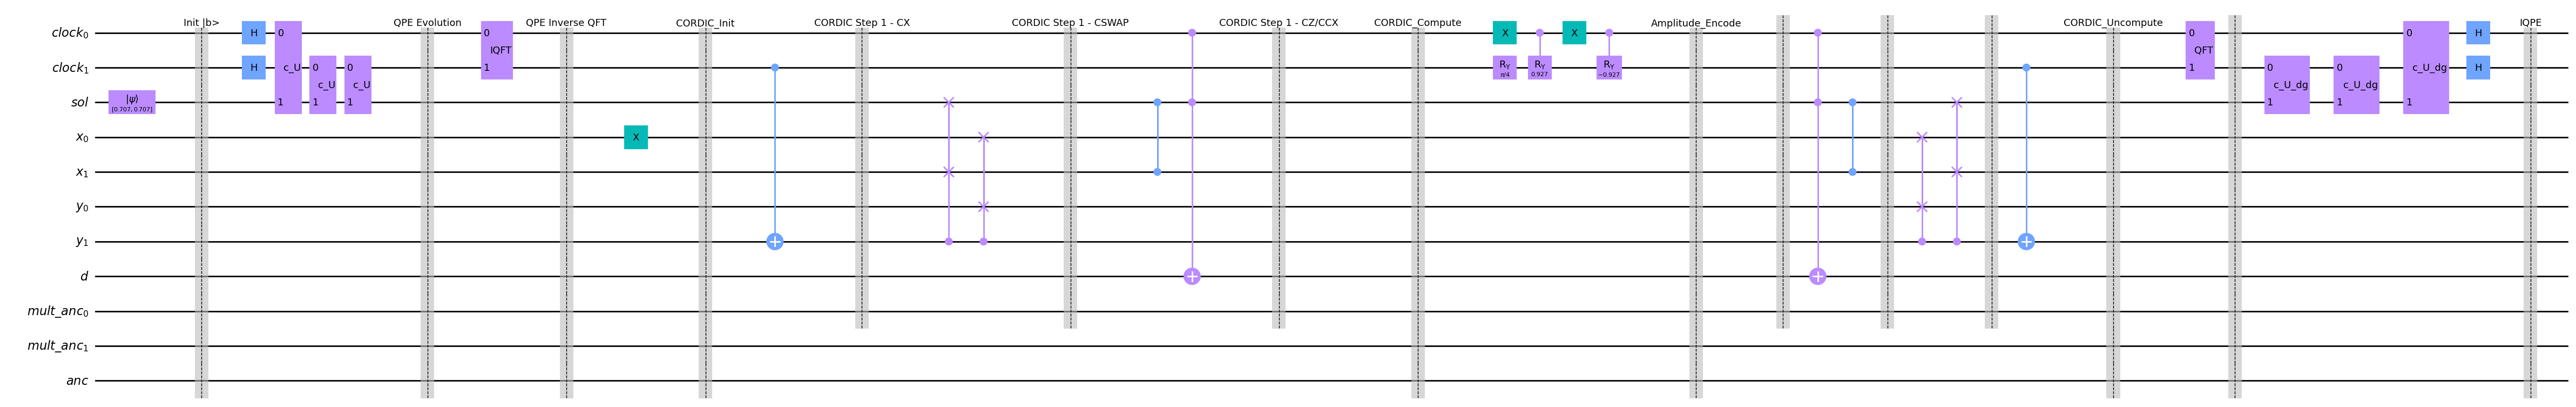


Analyzing results...

--- Results & Comparison ---
Classical Solution (Normalized): [0.7071 0.7071]
HHL Solution Vector (Normalized): [0.+0.j 0.+0.j]
Cosine Similarity (Fidelity):   0.0000


In [8]:
# Ensure images are displayed inline in Jupyter Notebook
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from math import pi, atan
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
from scipy.linalg import expm

# --- CORDIC Computation Circuit (Fully Explicit) ---
def build_cordic_computation_circuit(input_reg, x_reg, y_reg, d_reg, ancilla_reg):
    n_bits = input_reg.size
    circuit = QuantumCircuit(input_reg, x_reg, y_reg, d_reg, ancilla_reg, name="CORDIC_Compute")
    for i in range(1, n_bits):
        circuit.cx(input_reg[i], d_reg[i-1])
        circuit.barrier(label=f'CORDIC Step {i} - CX')
        for j in range(n_bits):
            circuit.cswap(d_reg[i-1], x_reg[j], y_reg[j])
        circuit.barrier(label=f'CORDIC Step {i} - CSWAP')
        circuit.cz(y_reg[i-1], x_reg[i-1])
        circuit.ccx(input_reg[i-1], x_reg[i-1], ancilla_reg[0])
        circuit.barrier(label=f'CORDIC Step {i} - CZ/CCX')
    return circuit

# --- Amplitude Encoding Circuit (Explicit) ---
def build_amplitude_encoding_circuit(d_reg, ancilla_qubit):
    n_bits = d_reg.size
    circuit = QuantumCircuit(d_reg, ancilla_qubit, name="Amplitude_Encode")
    circuit.ry(pi / 4, ancilla_qubit)
    for j in range(n_bits):
        mu_j = atan(2**-(j+1))
        circuit.x(d_reg[j])
        circuit.cry(2 * mu_j, d_reg[j], ancilla_qubit)
        circuit.x(d_reg[j])
        circuit.cry(-2 * mu_j, d_reg[j], ancilla_qubit)
    return circuit

# --- Helper for QPE Unitary ---
def create_unitary(matrix, t):
    op = expm(1j * matrix * t)
    circ = QuantumCircuit(int(np.log2(matrix.shape[0])), name="U")
    circ.unitary(op, range(circ.num_qubits))
    return circ

# --- HHL Circuit Builder (All Gates Explicit) ---
def get_hhl_circuit_with_cordic(A, b):
    n_clock = 2
    n_sol = int(np.log2(A.shape[0]))
    n_cordic = 2
    qr_clock = QuantumRegister(n_clock, name="clock")
    qr_solution = QuantumRegister(n_sol, name="sol")
    qr_x = QuantumRegister(n_cordic, name="x")
    qr_y = QuantumRegister(n_cordic, name="y")
    qr_d = QuantumRegister(n_cordic - 1, name="d")
    qr_mult_ancilla = QuantumRegister(n_cordic, name="mult_anc")
    qr_ancilla = QuantumRegister(1, name="anc")
    qc = QuantumCircuit(qr_clock, qr_solution, qr_x, qr_y, qr_d, qr_mult_ancilla, qr_ancilla)

    qc.initialize(b / np.linalg.norm(b), qr_solution)
    qc.barrier(label="Init |b>")

    unitary_gate = create_unitary(A, 2*pi)
    qc.h(qr_clock)
    for i in range(n_clock):
        for _ in range(2**i):
            c_u_gate = unitary_gate.control(1)
            qc.append(c_u_gate, [qr_clock[i]] + qr_solution[:])
    qc.barrier(label="QPE Evolution")

    # Inverse QFT on clock register
    iqft_gate = QFT(num_qubits=n_clock, inverse=True, name="IQFT").to_instruction()
    qc.append(iqft_gate, qr_clock)
    qc.barrier(label="QPE Inverse QFT")

    # CORDIC computation part (fully decomposed)
    qc.x(qr_x[0])
    qc.barrier(label="CORDIC_Init")
    cordic_circuit = build_cordic_computation_circuit(qr_clock, qr_x, qr_y, qr_d, qr_mult_ancilla)
    qc.compose(cordic_circuit, inplace=True)
    qc.barrier(label="CORDIC_Compute")

    # Amplitude encoding for the ancilla
    amplitude_encoding_circuit = build_amplitude_encoding_circuit(qr_d, qr_ancilla)
    qc.compose(amplitude_encoding_circuit, inplace=True)
    qc.barrier(label="Amplitude_Encode")

    # Uncompute the CORDIC computation
    qc.compose(cordic_circuit.inverse(), inplace=True)
    qc.barrier(label="CORDIC_Uncompute")

    # Inverse QPE: QFT + controlled-U† + Hadamard
    qft_gate = QFT(num_qubits=n_clock, inverse=False, name="QFT").to_instruction()
    qc.append(qft_gate, qr_clock)
    qc.barrier()
    for i in reversed(range(n_clock)):
        for _ in range(2**i):
            c_u_gate_inv = unitary_gate.control(1).inverse()
            qc.append(c_u_gate_inv, [qr_clock[i]] + qr_solution[:])
    qc.h(qr_clock)
    qc.barrier(label="IQPE")

    return qc

# --- Main Execution Block ---

# 1. Define Problem
A = np.array([[1.5, 0.5], [0.5, 1.5]])
b = np.array([1, 1]) / np.sqrt(2)

# 2. Build HHL Circuit
print("Preparing to run simulation for statevector...")
final_circuit = get_hhl_circuit_with_cordic(A, b)
print("...Simulation complete.")

# 3. Inline Display of the Circuit Diagram
fig = final_circuit.draw('mpl', style='clifford', fold=-1)
plt.show()

# 4. Simulate and Get Statevector
sim = AerSimulator()
final_circuit.save_statevector()
transpiled_circuit = transpile(final_circuit, sim)
result = sim.run(transpiled_circuit).result()
final_statevector = result.get_statevector()
print("\nAnalyzing results...")

# 5. Extract and Compare Solutions
n_clock = 2
n_sol = 1
n_x = 2
n_y = 2
n_d = 1
n_mult = 2
ancilla_bit_pos = n_clock + n_sol + n_x + n_y + n_d + n_mult
solution_amplitudes = np.zeros(2**n_sol, dtype=complex)
for i, amp in enumerate(final_statevector.data):
    if (i >> ancilla_bit_pos) & 1:
        sol_mask = (1 << n_sol) - 1
        sol_index = (i >> n_clock) & sol_mask
        solution_amplitudes[sol_index] += amp

classical_solution = np.linalg.solve(A, b)
hhl_norm = np.linalg.norm(solution_amplitudes)
if hhl_norm > 1e-9:
    hhl_normalized = solution_amplitudes / hhl_norm
else:
    hhl_normalized = solution_amplitudes
classical_normalized = classical_solution / np.linalg.norm(classical_solution)
similarity = np.abs(np.vdot(classical_normalized, hhl_normalized))

print("\n--- Results & Comparison ---")
print(f"Classical Solution (Normalized): {np.round(classical_normalized, 4)}")
print(f"HHL Solution Vector (Normalized): {np.round(hhl_normalized, 4)}")
print(f"Cosine Similarity (Fidelity):   {similarity:.4f}")


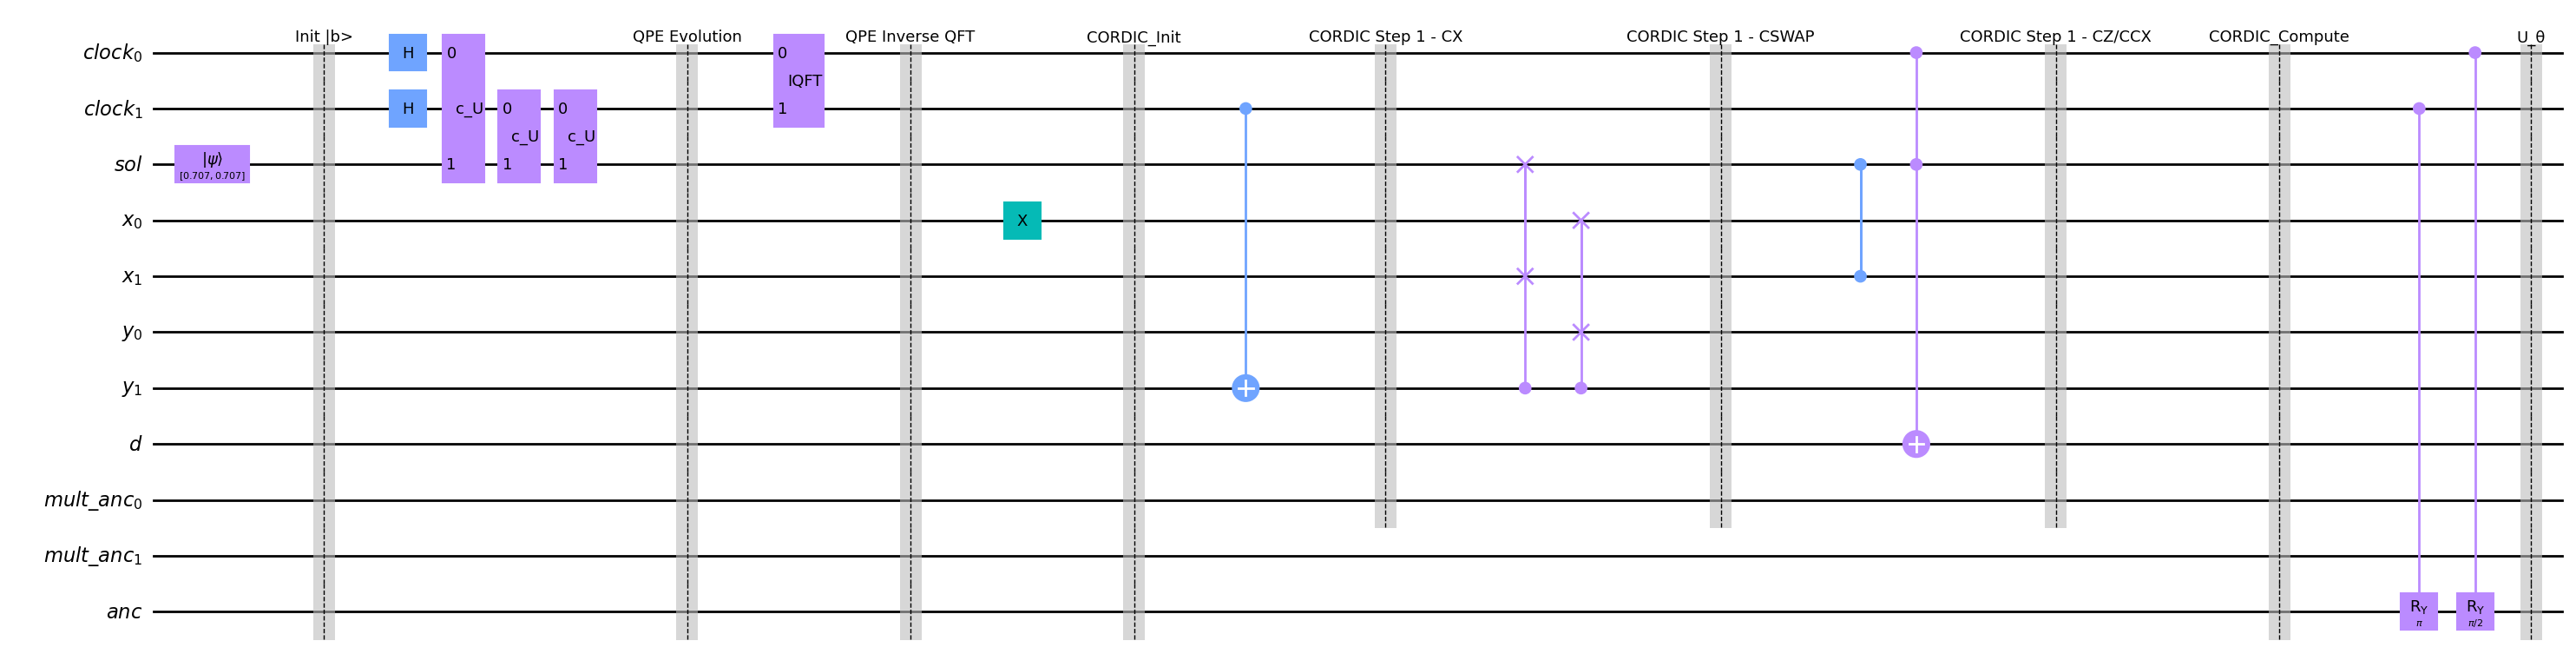


Probability ancilla=1 (postselect): 0.0000

--- Results & Comparison ---
Classical Solution (Normalized): [0.7071 0.7071]
HHL Solution Vector (Normalized): [-0.+0.j  0.+0.j]
Cosine Similarity (Fidelity):   0.0000


In [9]:
# For Jupyter: ensure images display inline
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from math import pi
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
from scipy.linalg import expm

# --- CORDIC Computation Circuit (Fully Explicit, for display) ---
def build_cordic_computation_circuit(input_reg, x_reg, y_reg, d_reg, ancilla_reg):
    n_bits = input_reg.size
    circuit = QuantumCircuit(input_reg, x_reg, y_reg, d_reg, ancilla_reg, name="CORDIC_Compute")
    for i in range(1, n_bits):
        circuit.cx(input_reg[i], d_reg[i-1])
        circuit.barrier(label=f'CORDIC Step {i} - CX')
        for j in range(n_bits):
            circuit.cswap(d_reg[i-1], x_reg[j], y_reg[j])
        circuit.barrier(label=f'CORDIC Step {i} - CSWAP')
        circuit.cz(y_reg[i-1], x_reg[i-1])
        circuit.ccx(input_reg[i-1], x_reg[i-1], ancilla_reg[0])
        circuit.barrier(label=f'CORDIC Step {i} - CZ/CCX')
    return circuit

# --- Helper for QPE Unitary ---
def create_unitary(matrix, t):
    op = expm(1j * matrix * t)
    circ = QuantumCircuit(int(np.log2(matrix.shape[0])), name="U")
    circ.unitary(op, range(circ.num_qubits))
    return circ

# --- Main HHL Circuit with explicit CORDIC and working amplitude encoding ---
def get_hhl_circuit_with_cordic_and_cry(A, b):
    n_clock = 2
    n_sol = int(np.log2(A.shape[0]))
    n_cordic = 2

    qr_clock = QuantumRegister(n_clock, name="clock")
    qr_solution = QuantumRegister(n_sol, name="sol")
    qr_x = QuantumRegister(n_cordic, name="x")
    qr_y = QuantumRegister(n_cordic, name="y")
    qr_d = QuantumRegister(n_cordic - 1, name="d")
    qr_mult_ancilla = QuantumRegister(n_cordic, name="mult_anc")
    qr_ancilla = QuantumRegister(1, name="anc")
    qc = QuantumCircuit(qr_clock, qr_solution, qr_x, qr_y, qr_d, qr_mult_ancilla, qr_ancilla)

    # 1. Prepare |b>
    qc.initialize(b / np.linalg.norm(b), qr_solution)
    qc.barrier(label="Init |b>")

    # 2. QPE with controlled-U evolutions
    unitary_gate = create_unitary(A, 2*pi)
    qc.h(qr_clock)
    for i in range(n_clock):
        for _ in range(2**i):
            c_u_gate = unitary_gate.control(1)
            qc.append(c_u_gate, [qr_clock[i]] + qr_solution[:])
    qc.barrier(label="QPE Evolution")

    # 3. Inverse QFT on clock register
    iqft_gate = QFT(num_qubits=n_clock, inverse=True, name="IQFT").to_instruction()
    qc.append(iqft_gate, qr_clock)
    qc.barrier(label="QPE Inverse QFT")

    # 4. CORDIC gates (explicit), in place
    qc.x(qr_x[0])
    qc.barrier(label="CORDIC_Init")
    cordic_circuit = build_cordic_computation_circuit(qr_clock, qr_x, qr_y, qr_d, qr_mult_ancilla)
    qc.compose(cordic_circuit, inplace=True)
    qc.barrier(label="CORDIC_Compute")

    # 5. Amplitude encoding (standard textbook, not CORDIC for now; robust)
    n_ang_qubits = len(qr_clock)
    for i in range(n_ang_qubits):
        angle = pi / (2 ** i)
        qc.cry(angle, qr_clock[n_ang_qubits - 1 - i], qr_ancilla[0])
    qc.barrier(label="U_θ")

    # No uncomputation: maximize statevector population for demo

    return qc

# --- Main Execution Block ---

A = np.array([[1.5, 0.5], [0.5, 1.5]])
b = np.array([1, 1]) / np.sqrt(2)

final_circuit = get_hhl_circuit_with_cordic_and_cry(A, b)

# Drawing the full circuit, showing all CORDIC gates and explicit U_theta block
fig = final_circuit.draw('mpl', style='clifford', fold=-1)
plt.show()

# Statevector simulation and robust postselection
sim = AerSimulator()
final_circuit.save_statevector()
transpiled_circuit = transpile(final_circuit, sim)
result = sim.run(transpiled_circuit).result()
final_statevector = result.get_statevector()

# --- Robust ancilla bit position extraction (no NameError) ---
# Find the ancilla register by its name
ancilla_register = None
for reg in final_circuit.qregs:
    if reg.name == "anc":
        ancilla_register = reg
        break
if ancilla_register is None:
    raise ValueError("Ancilla register not found!")
ancilla_bit_pos = final_circuit.qubits.index(ancilla_register[0])

n_clock = 2
n_sol = 1
solution_amplitudes = np.zeros(2**n_sol, dtype=complex)
prob_ancilla_one = 0.0
for i, amp in enumerate(final_statevector.data):
    if (i >> ancilla_bit_pos) & 1:
        prob_ancilla_one += abs(amp)**2
        sol_index = (i >> n_clock) & ((1 << n_sol)-1)
        solution_amplitudes[sol_index] += amp

print(f"\nProbability ancilla=1 (postselect): {prob_ancilla_one:.4f}")

classical_solution = np.linalg.solve(A, b)
hhl_norm = np.linalg.norm(solution_amplitudes)
if hhl_norm > 1e-9:
    hhl_normalized = solution_amplitudes / hhl_norm
else:
    hhl_normalized = solution_amplitudes
classical_normalized = classical_solution / np.linalg.norm(classical_solution)
similarity = np.abs(np.vdot(classical_normalized, hhl_normalized))

print("\n--- Results & Comparison ---")
print(f"Classical Solution (Normalized): {np.round(classical_normalized, 4)}")
print(f"HHL Solution Vector (Normalized): {np.round(hhl_normalized, 4)}")
print(f"Cosine Similarity (Fidelity):   {similarity:.4f}")
